## Objective: Final Prediction Computation

This notebook generates the final model predictions and formats them for submission on Codabench.

The evaluation dataset comprises data from 39 stations included in the training set and 13 stations exclusive to the evaluation set.

<img src="../images/notebook-4.png" alt="Experiment Diagram" style="width:75%;" style="text-align:center;" />

### 1. Imports

Starts by importing the necessary libraries, configuring environment paths, and loading custom utility functions.


In [1]:
import sys
import pandas as pd
import os
import zipfile

import joblib
import pandas as pd

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "..", "..")))

from src.utils.model import load_models_auto
from src.utils.analysis import create_predict_function, create_quantile_function
from src.utils.model import load_models_auto
from src.utils.model import (
    XGBQRF_SimpleModel,
    XGBQRFModel,
    Ensemble,
)

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Defines constants :

- _DATASET_DIR_ must be the directory where you unzip the _zenodo_ dataset.
- _EVAL_DIR_ will be used to store inference / evaluation data it must be the same as the one defined in _01 Training > 01 - Modelisation_
- _FINAL_MODEL_ will be used to store inference / evaluation data

FINAL_MODEL describe the model that will be loaded if you use auto-loading


In [2]:
ALPHA = 0.1
NUMBER_OF_WEEK = 4
USE_AUTO_SCAN = True  # Toggle this to switch between the loading of the last model of the manual load of a specific model
FINAL_MODEL = "xgb_qrf"

# Should be the same as in the training and feature engineering notebook
# This list should be the same as the one used in the previous notebook as it will be used to fetch the data
DATASET_TRANSFORMS = [
    "rm_gnv_st",  # Remove the geneva station (which is an outlier in the dataset) - Recommended
    "pca",  # Apply PCA to some of the static features (soil composition etc...) - Recommended
    "snow_index",  # Compute the snow index - probability of snow (which is a feature that's estimated from other features in the dataset) - Recommended
    # "snow_index_lag",  # Add lagged features of the snow index - Should be disabled if snow_index is not used
    # "oh_enc_date", # One hot encoding of the date - Not recommended use "cyc_enc_date" instead
    "cyc_enc_date",  # Cyclic encoding of the date - Recommended (https://developer.nvidia.com/blog/three-approaches-to-encoding-time-information-as-features-for-ml-models/)
    "clust_index",  # Clustering based on the location of the stations
    # "clust_index_oh",  # One hot encoding of the cluster index - Recommended
    "clust_hydro",  # Clustering based on the hydro features
    # "clust_hydro_oh",  # One hot encoding of the hydro cluster index - Recommended
    # "scl_feat", # Scaling to all the features - Not recommended for boosting models (Recommended for NN)
    # "scl_feat_wl",  # Scale all except waterflow lag
    # "rm_wl",  # remove custom generated water_flow_lag 3w & 4w ---> Need USE_CUSTOM_PREPROCESS = True
    "slct_ma",  # keep only specific mobile average 2w or/and 3w or/and 4w ---> Need USE_CUSTOM_PREPROCESS = True
    "lag_slope",  # add an indicator that is calculated between water_flow_lag 1w and 2w
    # "keep_precipitation_and_evaporation",  # keep precipitation and evaporation features without pca
    # "target_precipitation", # Lagged precipitation feature - experimental should be disabled
]

PCA_THRESHOLD = 0.98
N_CLUSTER = 5

# For the sake of simplicity we will use the fixed dataset name
# DATASET_SPEC = "_".join(DATASET_TRANSFORMS)
# # DATASET_SPEC = "custom_dataset_4"

# if "pca" in DATASET_TRANSFORMS:
#     DATASET_SPEC += f"_pct_{PCA_THRESHOLD}"

# if "clust_index" in DATASET_TRANSFORMS:
#     DATASET_SPEC += f"_geocl_{N_CLUSTER}"

# if "clust_hydro" in DATASET_TRANSFORMS:
#     DATASET_SPEC += f"_hydcl_{N_CLUSTER}"

DATASET_SPEC = "custom"

ADJUSTED_BONDS = False

EVAL_DIR = "../../../data/evaluation/"
EVAL_DIR_MINI = "../../../data/evaluation_mini/"
MODEL_DIR = f"../../../models/{DATASET_SPEC}/"

PREDS_DIR = f"{EVAL_DIR}{DATASET_SPEC}/{FINAL_MODEL}/"
COMPUTE_MINICHALLENGE = False


print(f"PREDS_DIR: {PREDS_DIR}")
os.makedirs(PREDS_DIR, exist_ok=True)

PREDS_DIR: ../../../data/evaluation/custom/xgb_qrf/


In [3]:
TARGET_COLUMNS = [f"water_flow_week{i+1}" for i in range(NUMBER_OF_WEEK)]

### 2. Data and models Loading

Loading of the inference dataset.


In [4]:
print(f"Loading dataset from dataset_{DATASET_SPEC}.csv")
# load the dataset
inference_data = pd.read_csv(f"{EVAL_DIR}dataset_{DATASET_SPEC}.csv")
inference_data = inference_data.set_index("ObsDate")

if COMPUTE_MINICHALLENGE:
    print("Loading mini challenge data")
    inference_data_mini = pd.read_csv(f"{EVAL_DIR_MINI}dataset_{DATASET_SPEC}.csv")
    inference_data_mini = inference_data_mini.set_index("ObsDate")
    inference_data = pd.concat([inference_data, inference_data_mini], axis=0)
    inference_data.fillna(0, inplace=True)

Loading dataset from dataset_custom.csv


In [5]:
for col in inference_data.columns:
    if inference_data[col].dropna().apply(lambda x: isinstance(x, bool)).any():
        inference_data[col] = inference_data[col].astype(int)

Loading of the final models.


In [6]:
# Load models based on conditions
final_models = []
if FINAL_MODEL == "mapie":
    if USE_AUTO_SCAN:
        final_models = load_models_auto("mapie_quantile", f"{MODEL_DIR}final/")
    else:
        final_models.append(
            joblib.load(
                f"{MODEL_DIR}final/mapie_quantile_2025-01-17_15-15-04_week0.pkl"
            )
        )
        final_models.append(
            joblib.load(
                f"{MODEL_DIR}final/mapie_quantile_2025-01-17_15-15-11_week1.pkl"
            )
        )
        final_models.append(
            joblib.load(
                f"{MODEL_DIR}final/mapie_quantile_2025-01-17_15-15-17_week2.pkl"
            )
        )
        final_models.append(
            joblib.load(
                f"{MODEL_DIR}final/mapie_quantile_2025-01-17_15-15-17_week3.pkl"
            )
        )
elif FINAL_MODEL == "qrf":

    if USE_AUTO_SCAN:
        final_models = load_models_auto("qrf_quantile", f"{MODEL_DIR}final/")
    else:
        final_models.append(
            joblib.load(f"{MODEL_DIR}final/qrf_quantile_2025-01-17_15-15-04_week0.pkl")
        )
        final_models.append(
            joblib.load(f"{MODEL_DIR}final/qrf_quantile_2025-01-17_15-15-11_week1.pkl")
        )
        final_models.append(
            joblib.load(f"{MODEL_DIR}final/qrf_quantile_2025-01-17_15-15-17_week2.pkl")
        )
        final_models.append(
            joblib.load(f"{MODEL_DIR}final/qrf_quantile_2025-01-17_15-15-17_week3.pkl")
        )
elif FINAL_MODEL == "gbr":

    if USE_AUTO_SCAN:
        final_models = load_models_auto("gbr_quantile", f"{MODEL_DIR}final/")
    else:
        final_models.append(
            joblib.load(f"{MODEL_DIR}final/qrf_quantile_2025-01-17_15-15-04_week0.pkl")
        )
        final_models.append(
            joblib.load(f"{MODEL_DIR}final/qrf_quantile_2025-01-17_15-15-11_week1.pkl")
        )
        final_models.append(
            joblib.load(f"{MODEL_DIR}final/qrf_quantile_2025-01-17_15-15-17_week2.pkl")
        )
        final_models.append(
            joblib.load(f"{MODEL_DIR}final/qrf_quantile_2025-01-17_15-15-17_week3.pkl")
        )
elif FINAL_MODEL == "qrf_voting":

    if USE_AUTO_SCAN:
        final_models = load_models_auto("qrf_voting_quantile", f"{MODEL_DIR}final/")
    else:
        final_models.append(
            joblib.load(f"{MODEL_DIR}final/qrf_quantile_2025-01-17_15-15-04_week0.pkl")
        )
        final_models.append(
            joblib.load(f"{MODEL_DIR}final/qrf_quantile_2025-01-17_15-15-11_week1.pkl")
        )
        final_models.append(
            joblib.load(f"{MODEL_DIR}final/qrf_quantile_2025-01-17_15-15-17_week2.pkl")
        )
        final_models.append(
            joblib.load(f"{MODEL_DIR}final/qrf_quantile_2025-01-17_15-15-17_week3.pkl")
        )
elif FINAL_MODEL == "qrf_bagging":

    if USE_AUTO_SCAN:
        final_models = load_models_auto("qrf_bagging_quantile", f"{MODEL_DIR}final/")
    else:
        final_models.append(
            joblib.load(f"{MODEL_DIR}final/qrf_quantile_2025-01-17_15-15-04_week0.pkl")
        )
        final_models.append(
            joblib.load(f"{MODEL_DIR}final/qrf_quantile_2025-01-17_15-15-11_week1.pkl")
        )
        final_models.append(
            joblib.load(f"{MODEL_DIR}final/qrf_quantile_2025-01-17_15-15-17_week2.pkl")
        )
        final_models.append(
            joblib.load(f"{MODEL_DIR}final/qrf_quantile_2025-01-17_15-15-17_week3.pkl")
        )
elif FINAL_MODEL == "lgbm":

    if USE_AUTO_SCAN:
        models_low = load_models_auto("lgbm_quantile_q0.05", f"{MODEL_DIR}final/")
        models_med = load_models_auto("lgbm_quantile_q0.5", f"{MODEL_DIR}final/")
        models_high = load_models_auto("lgbm_quantile_q0.95", f"{MODEL_DIR}final/")
        final_models = [[] for _ in range(NUMBER_OF_WEEK)]
        final_models[0] = [models_low[0], models_med[0], models_high[0]]
        final_models[1] = [models_low[1], models_med[1], models_high[1]]
        final_models[2] = [models_low[2], models_med[2], models_high[2]]
        final_models[3] = [models_low[3], models_med[3], models_high[3]]
    else:
        final_models.append(
            joblib.load(f"{MODEL_DIR}final/qrf_quantile_2025-01-17_15-15-04_week0.pkl")
        )
        final_models.append(
            joblib.load(f"{MODEL_DIR}final/qrf_quantile_2025-01-17_15-15-11_week1.pkl")
        )
        final_models.append(
            joblib.load(f"{MODEL_DIR}final/qrf_quantile_2025-01-17_15-15-17_week2.pkl")
        )
        final_models.append(
            joblib.load(f"{MODEL_DIR}final/qrf_quantile_2025-01-17_15-15-17_week3.pkl")
        )
elif FINAL_MODEL == "ebm_ensemble":
    print("Loading EBM Ensemble")
    if USE_AUTO_SCAN:
        final_models = load_models_auto("ebm_ensemble", f"{MODEL_DIR}final/")
    else:
        final_models.append(
            joblib.load(f"{MODEL_DIR}final/ebm_ensemble_2025-01-17_15-15-04_week0.pkl")
        )
        final_models.append(
            joblib.load(f"{MODEL_DIR}final/ebm_ensemble_2025-01-17_15-15-11_week1.pkl")
        )
        final_models.append(
            joblib.load(f"{MODEL_DIR}final/ebm_ensemble_2025-01-17_15-15-17_week2.pkl")
        )
        final_models.append(
            joblib.load(f"{MODEL_DIR}final/ebm_ensemble_2025-01-17_15-15-17_week3.pkl")
        )
elif FINAL_MODEL == "deep_ensemble":
    if USE_AUTO_SCAN:
        final_models = load_models_auto("deep_ensemble", f"{MODEL_DIR}final/")
    else:
        final_models.append(
            joblib.load(f"{MODEL_DIR}final/deep_ensemble_2025-01-17_15-15-04_week0.pkl")
        )
        final_models.append(
            joblib.load(f"{MODEL_DIR}final/deep_ensemble_2025-01-17_15-15-11_week1.pkl")
        )
        final_models.append(
            joblib.load(f"{MODEL_DIR}final/deep_ensemble_2025-01-17_15-15-17_week2.pkl")
        )
        final_models.append(
            joblib.load(f"{MODEL_DIR}final/deep_ensemble_2025-01-17_15-15-17_week3.pkl")
        )
elif FINAL_MODEL == "xgb":
    if USE_AUTO_SCAN:
        final_models = load_models_auto("xgb", f"{MODEL_DIR}final/")
elif FINAL_MODEL == "xgb_qrf":
    if USE_AUTO_SCAN:
        final_models = load_models_auto("xgb_qrf", f"{MODEL_DIR}final/")
elif FINAL_MODEL == "xgb_qrf_simple":
    if USE_AUTO_SCAN:
        final_models = load_models_auto("xgb_qrf_simple", f"{MODEL_DIR}final/")
elif FINAL_MODEL == "ensemble":
    if USE_AUTO_SCAN:
        final_models = load_models_auto("ensemble", f"{MODEL_DIR}final/")

Loading model for week 0: xgb_qrf_2025-05-25_11-38-06_week_0.pkl
Loading model for week 1: xgb_qrf_2025-05-25_11-38-15_week_1.pkl
Loading model for week 2: xgb_qrf_2025-05-25_11-38-24_week_2.pkl
Loading model for week 3: xgb_qrf_2025-05-25_11-38-33_week_3.pkl


### 3. Predictions computation

Evaluation data include a spatio-temporal split and a temporal only split.

<img src="../images/eval.png" alt="Experiment Diagram" style="width:50%;" />


In [7]:
import numpy as np

predictions = inference_data[["station_code"]].copy()
y_pred_test_quantile = {}
y_pred_test = {}
X_test = inference_data.drop(columns=["station_code"])

if len(set(TARGET_COLUMNS).intersection(list(X_test.columns))) > 0:
    X_test = X_test.drop(columns=TARGET_COLUMNS)


if FINAL_MODEL == "chained_qrf":
    # y_pred_test = final_models.predict(X_test, quantiles=[0.04, 0.5, 0.96])
    y_pred_test = final_models.predict(X_test)

    for i in range(NUMBER_OF_WEEK):
        predictions[f"week_{i}_pred"] = y_pred_test[i][:, 1]
        predictions[f"week_{i}_sup"] = y_pred_test[i][:, 2]
        predictions[f"week_{i}_inf"] = y_pred_test[i][:, 0]
else:
    for i in range(NUMBER_OF_WEEK):

        if FINAL_MODEL == "qrf":
            # reorder the columns
            X_test = X_test[final_models[0].feature_names_in_]

        print(FINAL_MODEL)
        predict_adjusted = create_predict_function(
            final_models, i, FINAL_MODEL, prev_week_models=final_models[:i]
        )
        quantile_adjusted = create_quantile_function(
            final_models, i, FINAL_MODEL, ALPHA, prev_week_models=final_models[:i]
        )

        y_pred_test[i] = predict_adjusted(X_test)
        y_pred_test_quantile[i] = quantile_adjusted(X_test)

        if FINAL_MODEL == "lgbm":
            y_pred_test_quantile[i][y_pred_test_quantile[i] < 0] = 0
            y_pred_test[i][y_pred_test[i] < 0] = 0

        if FINAL_MODEL == "xgb":
            y_pred_test_quantile[i][:, 0] *= 0.98
            y_pred_test_quantile[i][:, 1] *= 1.02

    for i in range(NUMBER_OF_WEEK):
        predictions[f"week_{i}_pred"] = y_pred_test[i]
        predictions[f"week_{i}_sup"] = y_pred_test_quantile[i][:, 1]
        predictions[f"week_{i}_inf"] = y_pred_test_quantile[i][:, 0]

xgb_qrf
model : xgb_qrf
xgb_qrf
model : xgb_qrf
xgb_qrf
model : xgb_qrf
xgb_qrf
model : xgb_qrf


### 4. Saving of the predictions


Saving of the predictions as a csv file

> The file must be named `predictions.csv`


In [8]:
X_test.columns

Index(['precipitations_lag_1w_pca_1', 'precipitations_lag_1w_pca_2',
       'precipitations_pca_1', 'precipitations_pca_2',
       'tempartures_lag_1w_pca_1', 'tempartures_pca_1', 'soil_moisture_pca_1',
       'soil_moisture_pca_2', 'soil_moisture_pca_3',
       'evaporation_lag_1w_pca_1', 'evaporation_pca_1',
       'soil_composition_pca_1', 'soil_composition_pca_2',
       'soil_composition_pca_3', 'soil_composition_pca_4',
       'soil_composition_pca_5', 'soil_composition_pca_6',
       'soil_composition_pca_7', 'latitude', 'longitude', 'catchment',
       'altitude', 'water_flow_lag_1w', 'water_flow_lag_2w',
       'water_flow_lag_3w', 'water_flow_lag_4w', 'water_flow_ma_4w_lag_1w',
       'water_flow_ma_4w_lag_1w_gauss', 'water_flow_ma_3w_lag_1w',
       'water_flow_ma_3w_lag_1w_gauss', 'water_flow_ma_2w_lag_1w',
       'water_flow_ma_2w_lag_1w_gauss', 'north_hemisphere', 'snow_index',
       'month_sin', 'month_cos', 'season_sin', 'season_cos', 'region_cluster',
       'hydro_cl

In [9]:
predictions[["week_1_inf", "week_1_pred", "week_1_sup"]], predictions.min()

(            week_1_inf  week_1_pred   week_1_sup
 ObsDate                                         
 2004-02-01   20.795827    38.442970    90.465827
 2004-04-25    7.464450    18.266022    36.915887
 2004-07-18    8.123019    14.442305    32.446590
 2004-10-10    1.706642     3.592499    13.212434
 2005-01-02    8.653769    17.285097    44.177483
 ...                ...          ...          ...
 2008-11-30  225.051209  1170.504761  3021.952659
 2009-02-22  697.891867   955.277954  1746.120780
 2009-05-17  618.204124   720.995667   930.749369
 2009-08-09  358.607945   431.010132   489.446629
 2009-11-01  339.162366   990.713684  1894.908461
 
 [1352 rows x 3 columns],
 station_code    6.119020e+06
 week_0_pred     3.947674e-02
 week_0_sup      6.273954e-02
 week_0_inf      0.000000e+00
 week_1_pred     5.109401e-02
 week_1_sup      1.036433e-01
 week_1_inf      0.000000e+00
 week_2_pred     5.775888e-02
 week_2_sup      1.435974e-01
 week_2_inf      0.000000e+00
 week_3_pred     5.827

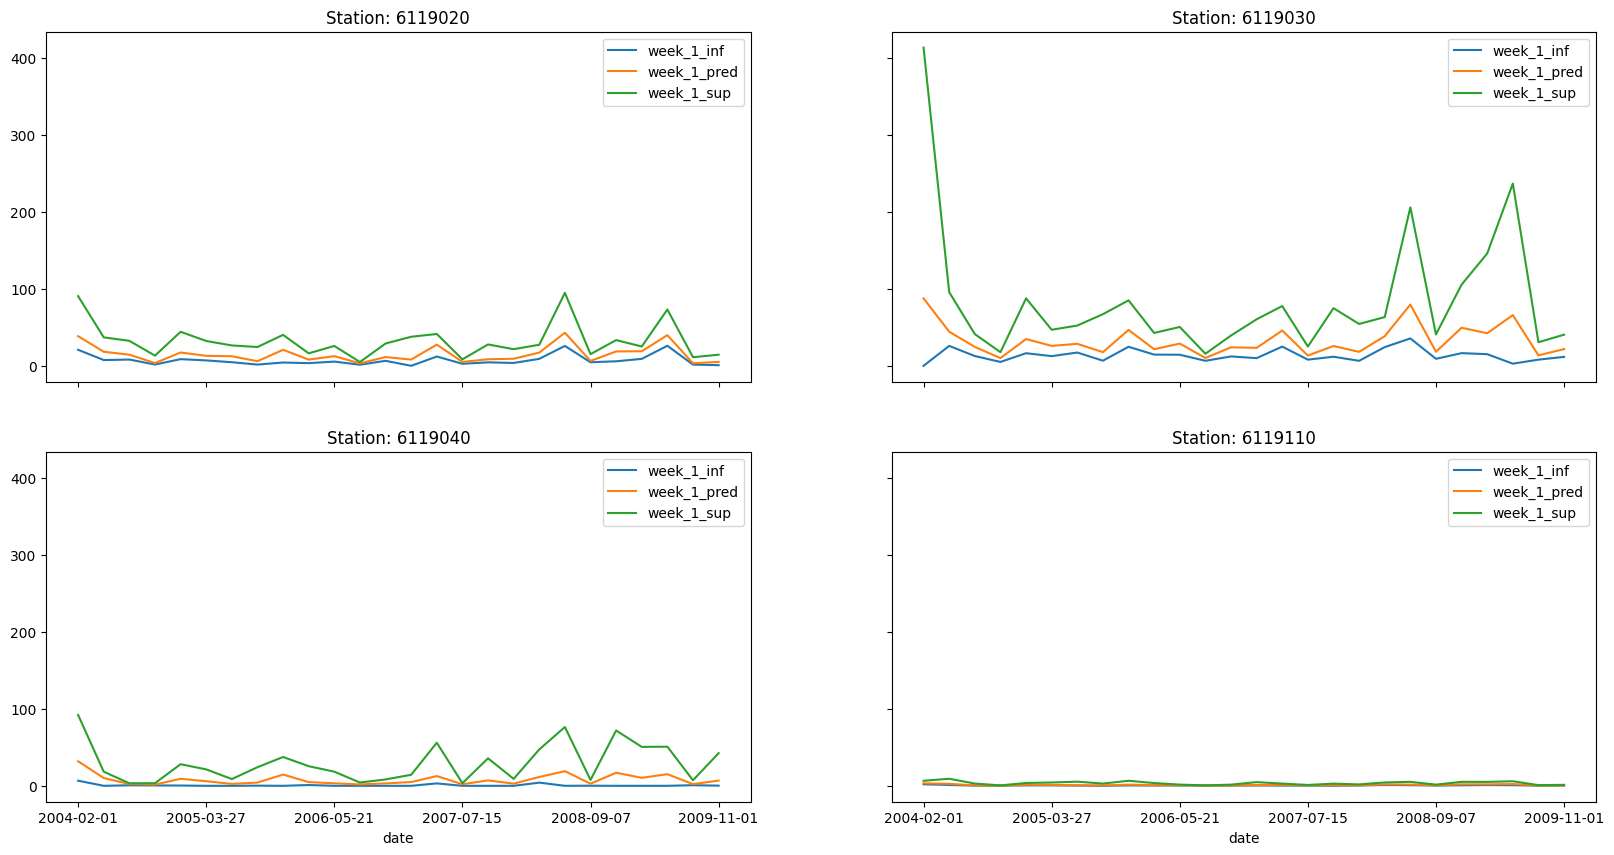

In [10]:
temp_predictions = predictions.copy()

temp_predictions["date"] = temp_predictions.index
temp_predictions = temp_predictions.sort_values(by="date")
temp_predictions = temp_predictions.groupby("station_code")

import matplotlib.pyplot as plt

fig, axes = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(20, 10),
    sharex=True,
    sharey=True,
)

for i, (station_code, group) in enumerate(temp_predictions):
    row = i // 2
    col = i % 2
    if row >= 2:
        break
    ax = axes[i // 2, i % 2]
    group.plot(
        kind="line", x="date", y=["week_1_inf", "week_1_pred", "week_1_sup"], ax=ax
    )
    ax.set_title(f"Station: {station_code}")

In [11]:
# save the predictions to a csv file
predictions["ObsDate"] = X_test.index
predictions.to_csv(f"{PREDS_DIR}predictions.csv", index=False)

Compression of the submission file.

> The file need to be compress for Codabench.


In [12]:
# Create a ZIP file containing predictions.csv
with zipfile.ZipFile(f"{PREDS_DIR}predictions.zip", "w", zipfile.ZIP_DEFLATED) as zipf:
    zipf.write(f"{PREDS_DIR}predictions.csv", "predictions.csv")

You are ready to submit go to codabench and submit the zip file that have been generated in My Submissions > Phase 1.

You don't have to use this notebook to submit but the file file format must includes the following columns:

- station_code: Identification code of the station.
- ObsDate: Date of the prediction.
- for every week of prediction i from 0 to 3 :
  - week_i_pred
  - week_i_inf
  - week_i_sup

Save the dataset as a CSV file named predictions.csv.

> The file must be named predictions.csv, but the .zip file can have any name.

Compress the CSV file into a .zip archive.

> You cannot submit an uncompressed file. Ensure that the software you use does not create a subfolder inside the archive.

Submit your file in [Codabench](https://www.codabench.org/competitions/4335):

> My Submissions > Phase 1 (keep all the tasks selected):

<img src="../images/submissions.png" alt="Experiment Diagram" style="width:75%;" style="text-align:center;" />
